### ANN for regression, example 2, house market data (how to handle categorical variables)

##### Version 2: using some common optimization approaches

#### Imports / modules

In [116]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

#### Loading the dataset

In [117]:
# load the data
df = pd.read_csv("Housing.csv")

In [118]:
# deep learning / neural network-wise, this is quite a small dataset
len(df)

545

<Axes: >

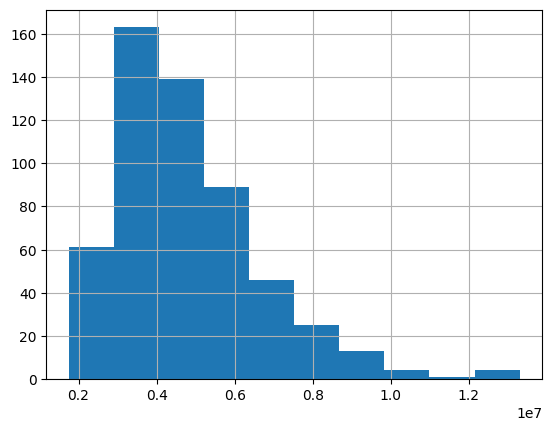

In [138]:
df['price'].hist()

In [119]:
# let's see the first 5 rows 
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


### REMEMBER! All data has to be numeric for the machine learning model (including neural networks!)

In [120]:
# check if we have any missing values
df.isna().sum()

# it seems we don't have any missing values

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [121]:
# we can also check duplicates
# in general, we don't want duplicate values in our dataset
# since it adds bias to the data (thus adding bias to the machine learning model)
int(df.duplicated().sum())

# no duplicates

0

### Handling the categorical variables

In [122]:
# WE HAVE SOME BOOLEAN CATEGORIES
# => change them to 0 and 1

# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder
variables = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [123]:
# let's see how our dataset now changed
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


### Convert text categories with multiple choices into multiple variables

In [124]:
# let's see the different options for furnishingstatus
# this is nominal category => USE ONEHOTENCODER 
df['furnishingstatus'].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [125]:
# this makes multiple columns with the variable (Separate for yes/no)
from sklearn.preprocessing import OneHotEncoder
variables = ['furnishingstatus']

# use encoder
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [126]:
# we can alwasy remove EXACTLY ONE option per variable when we use OneHotEncoder
df = df.drop("furnishingstatus_unfurnished", axis=1)

In [127]:
# let's see what happened to our dataset
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


### X/y -split

In [128]:
# perform X/y -split
# if you  have more than one independent variable, list them all here
# leave out the target variable! (dependent variable)

# this is a nice and common trick => everything EXCEPT target variable => support variable
X = df.drop("price", axis=1)

# have only the target variable here (dependent variable)
y = df["price"]

### Train/test/validation -split

In [129]:
# in Classic ML, we only had train/test -split
# in deep learning, we usually use validation-data also, for better
# optimization possibilities and better metrics

# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.

# if you want to split the test set into two for a validation set too, try this trick:

# step 1, split the data into 70% (training data) and 30% (temporary data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# step 2, split the temporary data in HALF (0.5) => 15% test and 15% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

#### Create a neural network structure

In [130]:
# create neural network

# save the amount of support variables into a helper variable
# so we don't have to update the input_shape all the time
variable_amount = len(X.columns)

# Define Sequential neural network model
# input shape has to match the amount of SUPPORT VARIABLES
# in other words => amount of columns in X 

# Tip: have at least the same number of nodes as in the input shape

# since we have 13 support variables this time => 16 nodes in first layer

# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.Dense(16, activation="relu", input_shape=(variable_amount,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

### Train the neural network

In [131]:
# train/fit neural network with validation data
# see the instructions on the train/test -split above on how to split the data correctly
model.fit(x=X_train, y=y_train, epochs=800, validation_data=(X_val, y_val))

Epoch 1/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 27358492884992.0000 - val_loss: 22619566899200.0000
Epoch 2/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27352341938176.0000 - val_loss: 22614430973952.0000
Epoch 3/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27346123882496.0000 - val_loss: 22608674291712.0000
Epoch 4/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27338607689728.0000 - val_loss: 22601478963200.0000
Epoch 5/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27328753172480.0000 - val_loss: 22591725109248.0000
Epoch 6/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27315148947456.0000 - val_loss: 22578624200704.0000
Epoch 7/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27297205714944.0000 - val_loss: 22561446428672.0000
Epoch 8/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27274007019520.0000 - val_loss: 22538597957632.0000
Epoch 9/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27243568955392.0000 - val_loss: 22508889702400.0000


### Performance and error metrics

<Axes: >

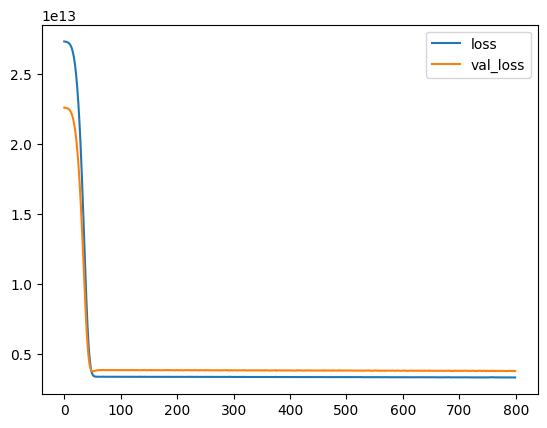

In [132]:
# let's use pandas for this (easy code)
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [133]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
2838164668416.0

Train data evaluation:
3287587225600.0


In [134]:
# get test predictions
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,Test True Y,Model Predictions
0,7700000,5638891.50
1,4893000,3016914.25
2,4543000,3573973.25
3,7455000,3750998.00
4,7560000,5232880.50
...,...,...
77,3500000,3177538.75
78,3150000,3043029.75
79,5110000,5295875.50
80,3500000,3056778.50


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

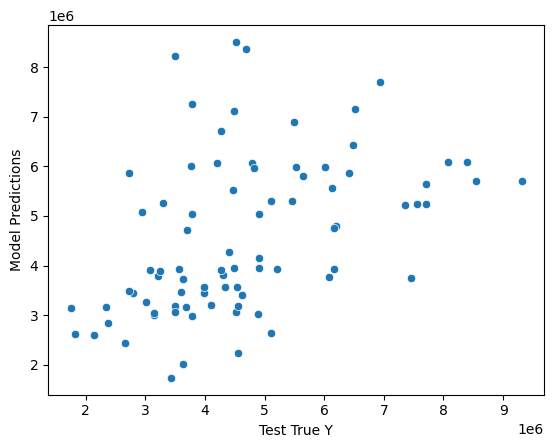

In [135]:
# these values follow a linear diagonal line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [136]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
1301733.25 $

MSE
2838164406272.0 $^2

RMSE:
1684685.25 $

R-squared:
-0.06

Explained variance score:
-0.05


C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_1488\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


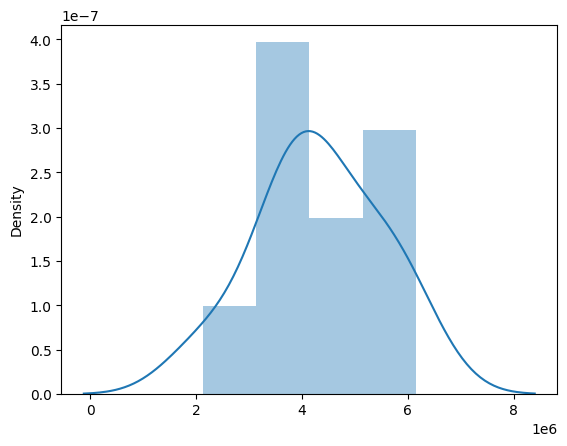

In [137]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

#### Trying the model in practice with new imaginary house

In [140]:
# just to see what kind of values are usually in the dataset
# so we can test with the tester_row
df.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1


In [147]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
    'area': 7420, 
    'bedrooms': 4, 
    'bathrooms': 2, 
    'stories': 3, 
    'mainroad': 1,
    'guestroom': 0, 
    'basement': 0, 
    'hotwaterheating': 0, 
    'airconditioning': 1,
    'parking': 2,
    'prefarea': 1,
    'furnishingstatus_furnished': 1,
    'furnishingstatus_semi-furnished:': 0
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [148]:
# get the prediction from the model and print out the result
result = model.predict(tester_row)[0]

print()
print(f"Estimated house price with this example:")
print(f"$ {round(float(result[0]), 2)}")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Estimated house price with this example:
$ 6454712.0
----------------


In [ ]:
# the model above undershoots the estimation
# should be 13.3 million => prediction is 6.45 million